# Constructing the Equity Curve

This notebook is written to construct the equity curve using the model we just built from notebook 'model_with_shap_instruction.ipynb'

It would require {ticker_name}_full.csv files, multiple models joblib files, which carry the models we trained from previous notebook.

In [5]:
## loading models
from joblib import dump, load
import sklearn
import numpy as np 
import pandas as pd
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns

## load all the helper functions written in scipt stats_check
from stats_check import *

import warnings
warnings.filterwarnings("ignore")


In [ ]:
# indicator_name = 'PR_INT_0'
# model_name = 'gb'
# model = load(f'../model_joblib/{ticker_name}_{model_name}_{indicator_name}.joblib') 
# base_model = load(f'../model_joblib/{ticker_name}_gb_base.joblib') 

In [6]:
ticker_name = 'OEX'
indicator_name = 'CMMA_10_252'
model_name = 'ridge'
model = load(f'./testing_data/{ticker_name}_{model_name}_{indicator_name}.joblib') 
base_model = load(f'./testing_data/{ticker_name}_{model_name}_base.joblib') 

In [7]:
df = pd.read_csv(f'./testing_data/{ticker_name}_full.csv')

df['Date'] = pd.to_datetime(df['Date'], format = '%Y%m%d')
df = df.set_index('Date')
for n in list(range(1,15)):
    name = 'ret' + str(n)
    df[name] = df['Open'].pct_change(periods=n)#for trading with open

df['retFut1'] = df['Open'].pct_change(1).shift(-1).fillna(0)
base_col = ['ret1', 'ret2', 'ret3', 'ret4', 'ret5', 'ret6', 'ret7', 'ret8', 'ret9',
    'ret10', 'ret11', 'ret12', 'ret13', 'ret14']


In [8]:

train_size = 0.75
no_rows = df.shape[0]
train_size = int(no_rows * train_size)
train, test = df[0:train_size], df[train_size: no_rows]
X_train = train.drop(['retFut1'], axis=1)
y_train = train[['retFut1']]
X_test = test.drop(['retFut1'], axis=1)
y_test = test[['retFut1']]

cagr, ratio, cagr_ratio = extra_model_eva(model, X_test[base_col + [indicator_name]], y_test)
print('the model with indicator has CAGR', cagr)

cagr_base, ratio, cagr_ratio = extra_model_eva(base_model, X_test[base_col], y_test)
print('the model without indicator has CAGR', cagr_base)

X_test_res = X_test.copy()

X_test_res['pred_ret'] = model.predict(X_test[base_col + [indicator_name]])
X_test_res['true_ret'] = y_test
X_test_res['pred_ret_base'] = base_model.predict(X_test[base_col])
X_test_res['pred_cumret_ind'] = np.cumprod( ((X_test_res['pred_ret'] * X_test_res['true_ret']) ) + 1)  - 1
X_test_res['pred_cumret_base'] = np.cumprod( ((X_test_res['pred_ret_base'] * X_test_res['true_ret']) ) + 1)  - 1

X_test_res['true_open'] = df['Open'][train_size: no_rows]


the model with indicator has CAGR 3.246654416479517
the model without indicator has CAGR 0.1745692130389167


Text(0.5, 0.98, 'OEX Returns(actual, predicted) with CMMA_10_252')

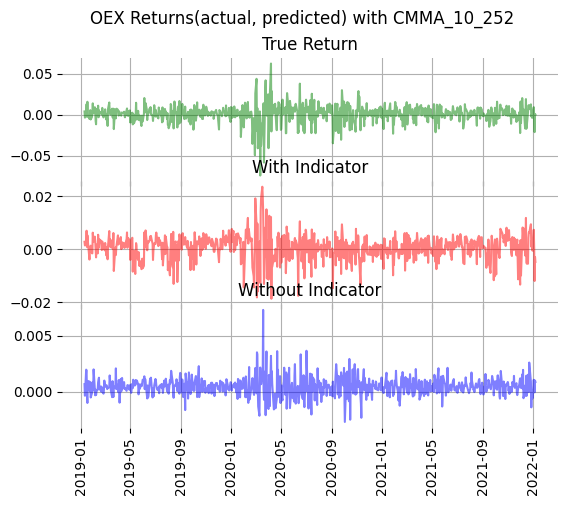

In [9]:

fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, subplot_kw=dict(frameon=False)) 

plt.subplots_adjust(hspace=.0)

plt.xticks(rotation=90)
ax1.grid()
ax2.grid()
ax3.grid()
ax1.plot(X_test_res.index, X_test_res['true_ret'], label = "True Return", linestyle="-", color = 'green',alpha = 0.5)
ax1.title.set_text('True Return')
ax2.plot(X_test_res.index, X_test_res['pred_ret'], label = "With Ind", linestyle="-", color = 'red', alpha = 0.5)
ax2.title.set_text('With Indicator')
ax3.plot(X_test_res.index, X_test_res['pred_ret_base'], linestyle="-", color = 'blue', alpha = 0.5)
ax3.title.set_text('Without Indicator')
fig.suptitle(f'{ticker_name} Returns(actual, predicted) with {indicator_name}')

# fig.savefig(f'../imgs/{ticker_name}_{indicator_name}_returns')

Text(0.5, 0.98, 'OEX Equity Curve (Return) with CMMA_10_252')

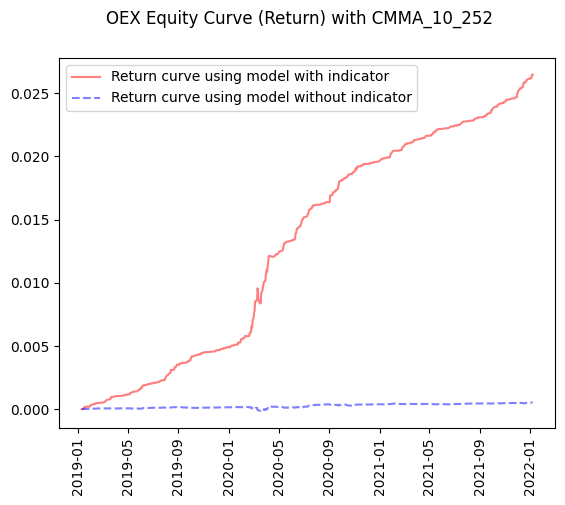

In [10]:
plt.plot(X_test_res.index, X_test_res['pred_cumret_ind'], label = "Return curve using model with indicator", linestyle="-", color = 'red',alpha = 0.5)
plt.plot(X_test_res.index, X_test_res['pred_cumret_base'], label = "Return curve using model without indicator", linestyle="--", color = 'blue', alpha = 0.5)
plt.xticks(rotation=90)
plt.legend()
plt.suptitle(f'{ticker_name} Equity Curve (Return) with {indicator_name}')
# plt.savefig(f'../imgs/{ticker_name}_{indicator_name}_curve')

average return 0.000151
[-4.06974377e-05  4.69218999e-05]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


Text(0.5, 1.0, 'White Reality Check with indicator')

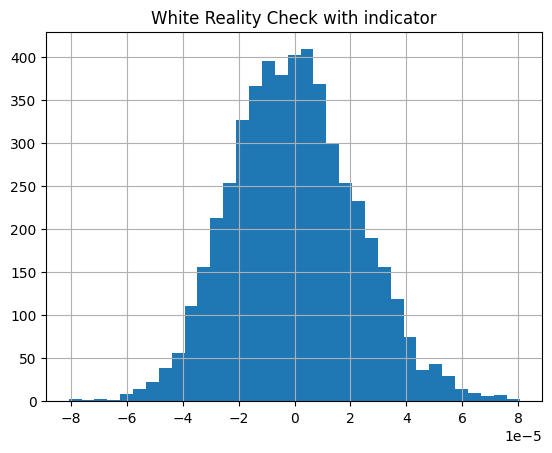

In [11]:
detrended_open = detrendPrice(X_test_res['true_open'] )
detrended_retFut1 = detrended_open.pct_change(periods=1).shift(-1).fillna(0)
detrended_syst_rets = detrended_retFut1 * pd.Series(list(X_test_res['pred_ret'])).fillna(0)
bootstrap(detrended_syst_rets)
plt.title('White Reality Check with indicator')
# plt.savefig(f'../imgs/{ticker_name}_{indicator_name}_white_reality')

average return 0.000003
[-7.35737684e-06  7.86538968e-06]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.22099999999999997


Text(0.5, 1.0, 'White Reality Check without indicator')

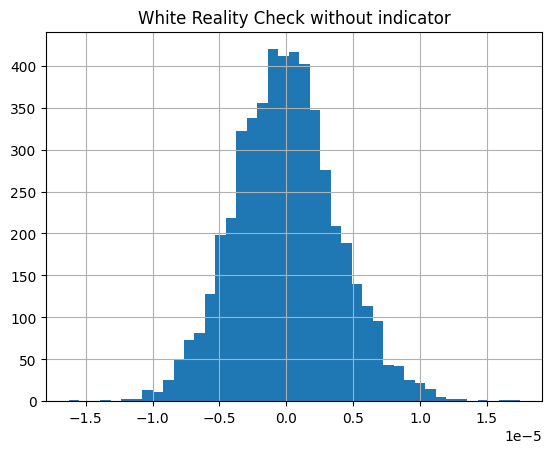

In [12]:
detrended_syst_rets = detrended_retFut1 * pd.Series(list(X_test_res['pred_ret_base'])).fillna(0)
bootstrap(detrended_syst_rets)
plt.title('White Reality Check without indicator')
# plt.savefig(f'../imgs/{ticker_name}_base_white_reality')

## This section is used to compare RSI models

We comment it for now because we do not run the model for RSI's in previous notebook.

In [ ]:
## this part is for comparing RSI's models, we comment it out for now

# rsi20_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_20.joblib') 
# rsi25_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_25.joblib') 
# rsi20ta_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_20_ta.joblib') 
# rsi25ta_model = load(f'../model_joblib/{ticker_name}_{model_name}_RSI_25_ta.joblib') 

# X_test_ta = X_test.copy()

# X_test_ta['pred_ret_rsi20'] = rsi20_model.predict(X_test[base_col + ['RSI_20']])
# X_test_ta['pred_ret_rsi25'] = rsi25_model.predict(X_test[base_col + ['RSI_25']])
# X_test_ta['pred_ret_rsi20ta'] = rsi20ta_model.predict(X_test[base_col + ['RSI_20_ta']])
# X_test_ta['pred_ret_rsi25ta'] = rsi25ta_model.predict(X_test[base_col + ['RSI_25_ta']])
# X_test_ta['true_ret'] = y_test


# X_test_ta['pred_cumret_rsi20'] = np.cumprod( ((X_test_ta['pred_ret_rsi20'] * X_test_ta['true_ret']) ) + 1)  - 1
# X_test_ta['pred_cumret_rsi25'] = np.cumprod( ((X_test_ta['pred_ret_rsi25'] * X_test_ta['true_ret']) ) + 1)  - 1
# X_test_ta['pred_cumret_rsi20ta'] = np.cumprod( ((X_test_ta['pred_ret_rsi20ta'] * X_test_ta['true_ret']) ) + 1)  - 1
# X_test_ta['pred_cumret_rsi25ta'] = np.cumprod( ((X_test_ta['pred_ret_rsi25ta'] * X_test_ta['true_ret']) ) + 1)  - 1



In [ ]:
# import antropy as ant
# print(f'RSI 20 has antropy: ', ant.perm_entropy(X_test_ta['RSI_20'], normalize=True))
# print(f'RSI 25 has antropy: ', ant.perm_entropy(X_test_ta['RSI_25'], normalize=True))
# print(f'RSI talib 20 has antropy: ', ant.perm_entropy(X_test_ta['RSI_20_ta'], normalize=True))
# print(f'RSI talib 25 has antropy: ', ant.perm_entropy(X_test_ta['RSI_25_ta'], normalize=True))


In [ ]:
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi20'], label = "Return curve RSI 20", linestyle="-", color = 'blue',alpha = 0.5)
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi25'], label = "Return curve RSI 25", linestyle="-", color = 'purple', alpha = 0.5)
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi20ta'], label = "Return curve RSI 20 Talib", linestyle="-", color = 'red',alpha = 0.5)
# plt.plot(X_test_ta.index, X_test_ta['pred_cumret_rsi25ta'], label = "Return curve RSI 25 Talib", linestyle="-", color = 'orange', alpha = 0.5)
# plt.xticks(rotation=90)
# plt.legend()
# plt.suptitle(f'{ticker_name} Equity Curve (Return) Comparison Over RSI')
# # plt.savefig(f'../imgs/{ticker_name}_RSI_curve')

In [ ]:
# dt_peak_analysis = X_test_ta[ (X_test_ta.index > '2020-03-01') & (X_test_ta.index < '2020-05-01') ]
# dt_peak_analysis['retFut1'] = y_test
# dt_peak_analysis['retFut1_diff'] = dt_peak_analysis['retFut1'].diff()
# color_dict = {
#     'Open':'pink',
#     'retFut1':'black',
#     'retFut1_diff':'grey',
#     'pred_cumret_rsi20':'blue',
#     'pred_cumret_rsi25':'purple',
#     'pred_cumret_rsi20ta':'red',
#     'pred_cumret_rsi25ta':'orange'
# }

# name_dict = {
#     'Open':'Price',
#     'retFut1':'Future Return',
#     'retFut1_diff':'Future Return diff',
#     'pred_cumret_rsi20':'Cumulative_return_RSI20',
#     'pred_cumret_rsi25':'Cumulative_return_RSI25',
#     'pred_cumret_rsi20ta':'Cumulative_return_RSI20_talib',
#     'pred_cumret_rsi25ta':'Cumulative_return_RSI25_talib'
# }

In [ ]:


# col_names = ['Open','retFut1','retFut1_diff','pred_cumret_rsi20','pred_cumret_rsi25','pred_cumret_rsi20ta','pred_cumret_rsi25ta']

# fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 10), sharex=True,)
# plt.subplots_adjust(hspace=0.5)
# plt.xticks(rotation=90)
# for idx, colname in enumerate(col_names):
#     axes[idx].plot(dt_peak_analysis.index, dt_peak_analysis[colname], label = colname, linestyle="-", color = color_dict[colname],alpha = 0.5)
#     axes[idx].title.set_text(name_dict[colname])
#     axes[idx].axvline(datetime.datetime(2020, 3, 11), alpha = 0.8)
#     axes[idx].axvline(datetime.datetime(2020, 3, 20), alpha = 0.2)
#     axes[idx].axvline(datetime.datetime(2020, 3, 31), alpha = 0.2)
#     axes[idx].axvline(datetime.datetime(2020, 4, 7), alpha = 0.2)
# plt.savefig(f'../imgs/{ticker_name}_peak_analysis')